Date: 2016-10-21

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

sys.path.append('../src/')
import data_processing
import ripple_decoding
import ripple_detection

In [2]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = data_processing.make_epochs_dataframe(animals, days)
tetrode_info = data_processing.make_tetrode_dataframe(animals)
epoch_index = (epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'].index)

cur_tetrode_info = tetrode_info[epoch_index[0]]
cur_tetrode_info

area  depth descrip  numcells animal  \
animal day epoch_ind tetrode_number                                         
HPa    8   2         1                CA1    113  riptet        12    HPa   
                     2                CA1    121     NaN         0    HPa   
                     3                CA1     90  CA1Ref         0    HPa   
                     4                CA1    116  riptet        15    HPa   
                     5                CA1    116  riptet         0    HPa   
                     6                CA1    110  riptet         0    HPa   
                     7                CA1    114  riptet         0    HPa   
                     8               iCA1    114  riptet         0    HPa   
                     9               iCA1    100  riptet         0    HPa   
                     10              iCA1     96     NaN         0    HPa   
                     11              iCA1    106  riptet         0    HPa   
                     12              iCA1    114  riptet         3    HPa   
                     13              iCA1    120     NaN         0    HPa   
                     14              iCA1    105  riptet         6    HPa   
                     15               PFC     93     NaN         0    HPa   
                     16               PFC     90     NaN         0    HPa   
                     17               PFC     90     NaN         6    HPa   
                     18               PFC     90     NaN         0    HPa   
                     19               PFC    130     NaN         0    HPa   
                     20               PFC    109     NaN         0    HPa   

                                     day  epoch_ind  tetrode_number tetrode_id  
animal day epoch_ind tetrode_number                                             
HPa    8   2         1                 8          2               1     HPa821  
                     2                 8          2               2     HPa822  
                     3                 8          2               3     HPa823  
                     4                 8          2               4     HPa824  
                     5                 8          2               5     HPa825  
                     6                 8          2               6     HPa826  
                     7                 8          2               7     HPa827  
                     8                 8          2               8     HPa828  
                     9                 8          2               9     HPa829  
                     10                8          2              10    HPa8210  
                     11                8          2              11    HPa8211  
                     12                8          2              12    HPa8212  
                     13                8          2              13    HPa8213  
                     14                8          2              14    HPa8214  
                     15                8          2              15    HPa8215  
                     16                8          2              16    HPa8216  
                     17                8          2              17    HPa8217  
                     18                8          2              18    HPa8218  
                     19                8          2              19    HPa8219  
                     20                8          2              20    HPa8220

In [3]:
neuron_info = data_processing.make_neuron_dataframe(animals)[epoch_index[0]].dropna()
tetrode_info = data_processing.make_tetrode_dataframe(animals)[epoch_index[0]]
neuron_info = pd.merge(tetrode_info, neuron_info,
                       on=['animal', 'day', 'epoch_ind', 'tetrode_number', 'area'],
                       how='right', right_index=True).set_index(neuron_info.index)
neuron_info = neuron_info[neuron_info.area.isin(['CA1', 'iCA1']) &
                          (neuron_info.numspikes > 0) &
                          ~neuron_info.descrip.str.endswith('Ref').fillna(False)]

In [4]:
trial_info = data_processing.get_interpolated_position_dataframe(epoch_index[0], animals)
trial_info

,trajectory_category_ind,trajectory_direction,trajectory_turn,trial_number,linear_distance,x_position,y_position,head_direction,speed,linear_position
time,,,,,,,,,,
2712.994800,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.995467,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.996133,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.996800,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.997467,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.998133,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.998800,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2712.999467,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235
2713.000133,0.0,Outbound,Left,1.0,0.931162,96.411070,105.570044,-0.244134,3.076491,0.931235


In [5]:
spikes_data = [data_processing.get_spike_indicator_dataframe(neuron_index, animals)
               for neuron_index in neuron_info.index]
spikes_data[0]

# Make sure there are spikes in the training data times. Otherwise exclude that neuron
MEAN_RATE_THRESHOLD = 0.10  # in Hz
sampling_frequency = 1500
spikes_data = [spikes_datum for spikes_datum in spikes_data
               if spikes_datum[trial_info.speed > 4].is_spike.mean() *
               sampling_frequency > MEAN_RATE_THRESHOLD]

### Only train on data when the rat is moving

In [6]:
train_trial_info = trial_info.query('speed > 4')
train_spikes_data = [spikes_datum[trial_info.speed > 4]
                     for spikes_datum in spikes_data]

### Encoding Model

#### Train model

In [7]:
formula = '1 + trajectory_direction * bs(linear_distance, df=10, degree=3)';
design_matrix = patsy.dmatrix(formula, train_trial_info, return_type='dataframe')
fit = [sm.GLM(spikes, design_matrix, family=sm.families.Poisson()).fit(maxiter=30)
       for spikes in tqdm.tqdm_notebook(train_spikes_data, desc='fit')]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


#### Get predicted conditional intensities

In [8]:
linear_distance_grid = np.linspace(0, 192, 49)
linear_distance_grid_centers = linear_distance_grid[:-1] + np.diff(linear_distance_grid) / 2

def predictors_by_trajectory_direction(trajectory_direction, linear_distance_grid_centers, design_matrix):
    predictors = {'linear_distance': linear_distance_grid_centers,
                  'trajectory_direction': [trajectory_direction] * len(linear_distance_grid_centers)}
    return patsy.build_design_matrices([design_matrix.design_info], predictors)[0]

inbound_predict_design_matrix = predictors_by_trajectory_direction('Inbound',
                                                                   linear_distance_grid_centers,
                                                                   design_matrix)
outbound_predict_design_matrix = predictors_by_trajectory_direction('Outbound',
                                                                    linear_distance_grid_centers,
                                                                    design_matrix)

def get_conditional_intensity(fit, predict_design_matrix):
    return np.vstack([fitted_model.predict(predict_design_matrix)
                      for fitted_model in fit]).T

inbound_conditional_intensity = get_conditional_intensity(fit, inbound_predict_design_matrix)
outbound_conditional_intensity = get_conditional_intensity(fit, outbound_predict_design_matrix)

#### Plot model fits for each neuron to check fit quality
Neurons HPa8245 and HPa8248 appear to have poor fits. What should we do about poor fits?

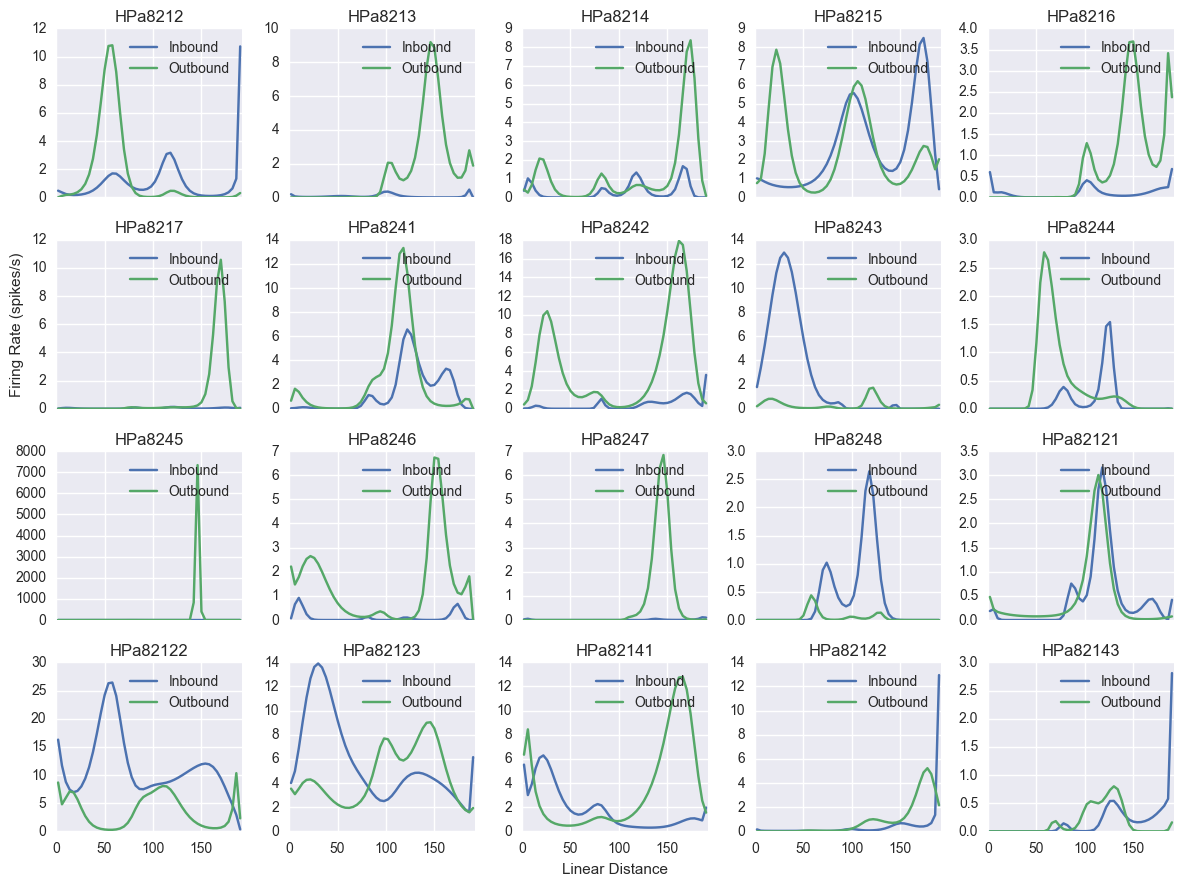

In [9]:
num_neurons = len(fit)
col_wrap = 5
num_plot_rows = int(np.ceil(num_neurons / col_wrap))
fig, axes = plt.subplots(nrows=num_plot_rows, ncols=col_wrap, figsize=(12, 9), sharex=True)
sampling_frequency = 1500

for neuron_ind, ax in enumerate(axes.flatten()[:num_neurons]):
    ax.plot(linear_distance_grid_centers,
            fit[neuron_ind].predict(inbound_predict_design_matrix) * sampling_frequency,
            label='Inbound')
    ax.plot(linear_distance_grid_centers,
            fit[neuron_ind].predict(outbound_predict_design_matrix) * sampling_frequency,
            label='Outbound')
    ax.legend()
    ax.set_xlim((linear_distance_grid.min(), linear_distance_grid.max()))
    ax.set_title(neuron_info.neuron_id[neuron_ind])

middle_column = int(np.ceil(col_wrap / 2) - 1)
middle_row = int(np.ceil(num_plot_rows / 2) - 1)
axes[-1, middle_column].set_xlabel('Linear Distance')
axes[middle_row, 0].set_ylabel('Firing Rate (spikes/s)')
plt.tight_layout()

#### Compare to raw spikes

##### Inbound

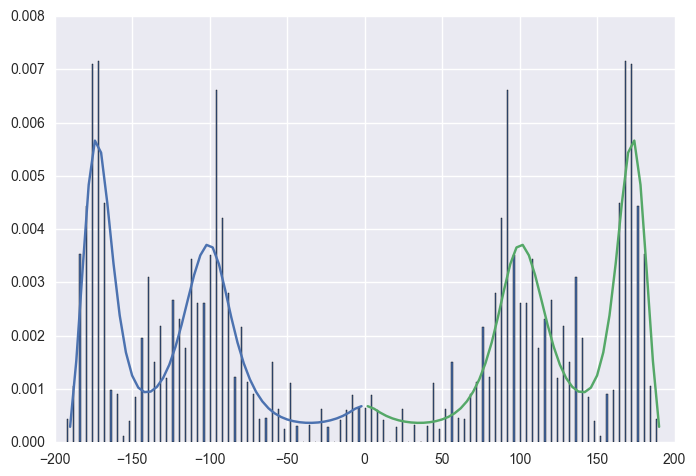

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def occupancy_normalized_histogram(stat_at_spike, stat, bins, ax=None, bar_plot_kwargs={}):
    if ax is None:
        ax = plt.gca()
    occupancy, _ = np.histogram(stat, bins=bins)
    binned_stat_at_spike, _ = np.histogram(stat_at_spike, bins=bins)
    ax.bar(bins[:-1], binned_stat_at_spike / occupancy, **bar_plot_kwargs)

neuron_ind = 3
distance_at_spike = (pd.concat([train_trial_info, train_spikes_data[neuron_ind]], axis=1)
                .query('(is_spike > 0) & (trajectory_direction == "Inbound")').linear_distance)


fig, ax = plt.subplots(1)
ax.plot(-linear_distance_grid_centers,
            fit[neuron_ind].predict(inbound_predict_design_matrix),
            label='Inbound')
ax.plot(linear_distance_grid_centers,
            fit[neuron_ind].predict(inbound_predict_design_matrix),
            label='Inbound')

occupancy_normalized_histogram(
    -distance_at_spike,
    -train_trial_info.query('trajectory_direction == "Inbound"').linear_distance,
    -linear_distance_grid[::-1], ax=ax)

occupancy_normalized_histogram(
    distance_at_spike,
    train_trial_info.query('trajectory_direction == "Inbound"').linear_distance,
    linear_distance_grid, ax=ax)



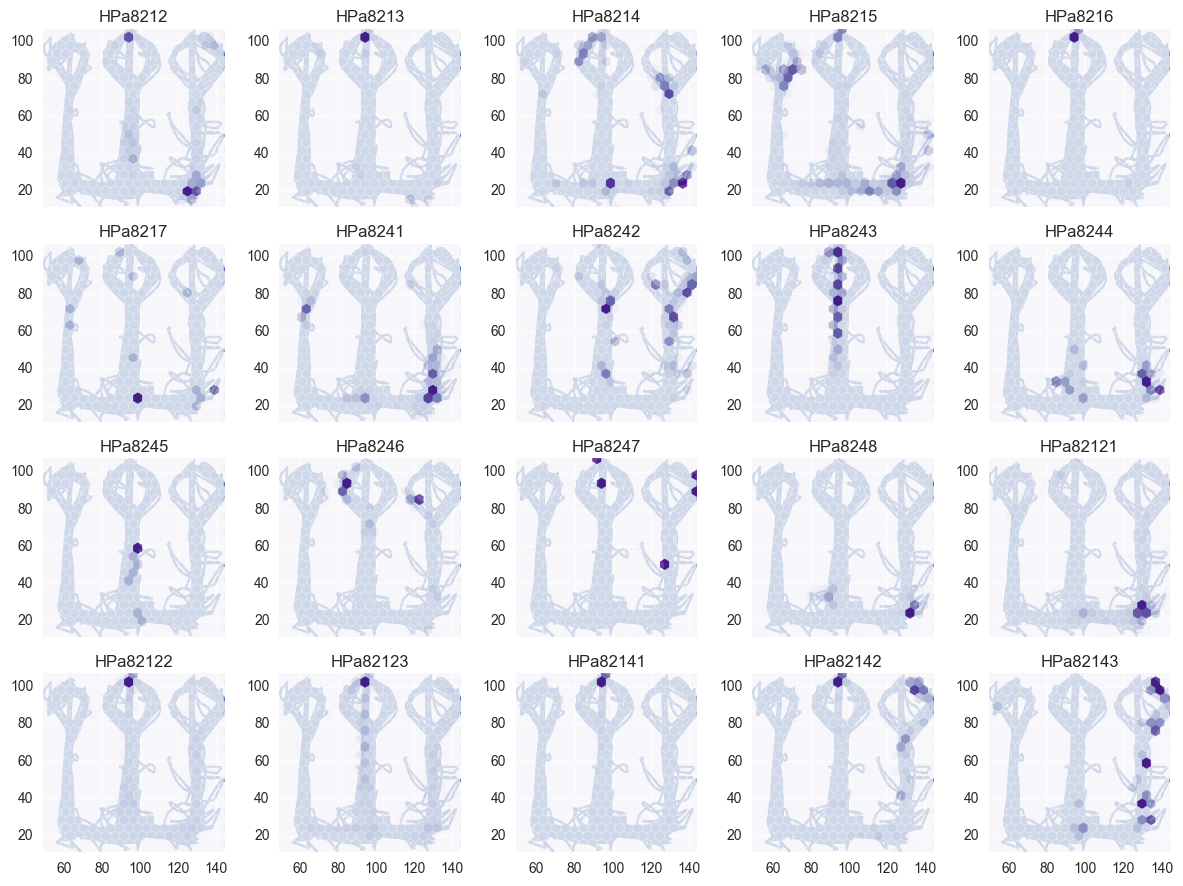

In [11]:
num_neurons = len(fit)
col_wrap = 5
num_plot_rows = int(np.ceil(num_neurons / col_wrap))
fig, axes = plt.subplots(nrows=num_plot_rows, ncols=col_wrap, figsize=(12, 9), sharex=True)
extent = (np.fix(train_trial_info.x_position.min()),
          np.fix(train_trial_info.x_position.max()),
          np.fix(train_trial_info.y_position.min()),
          np.fix(train_trial_info.y_position.max()))

for neuron_ind, ax in enumerate(axes.flatten()[:num_neurons]):
    df = (pd.concat([train_trial_info, train_spikes_data[neuron_ind]], axis=1)
            .query('(is_spike > 0) & (trajectory_direction == "Inbound")'))
    ax.plot(train_trial_info.x_position, train_trial_info.y_position, zorder=1)
    ax.hexbin(df.x_position, df.y_position, zorder=2, alpha=0.75,
              gridsize=20, extent=extent, cmap='Purples')
    ax.set_title(neuron_info.neuron_id[neuron_ind])

plt.tight_layout()

##### Outbound

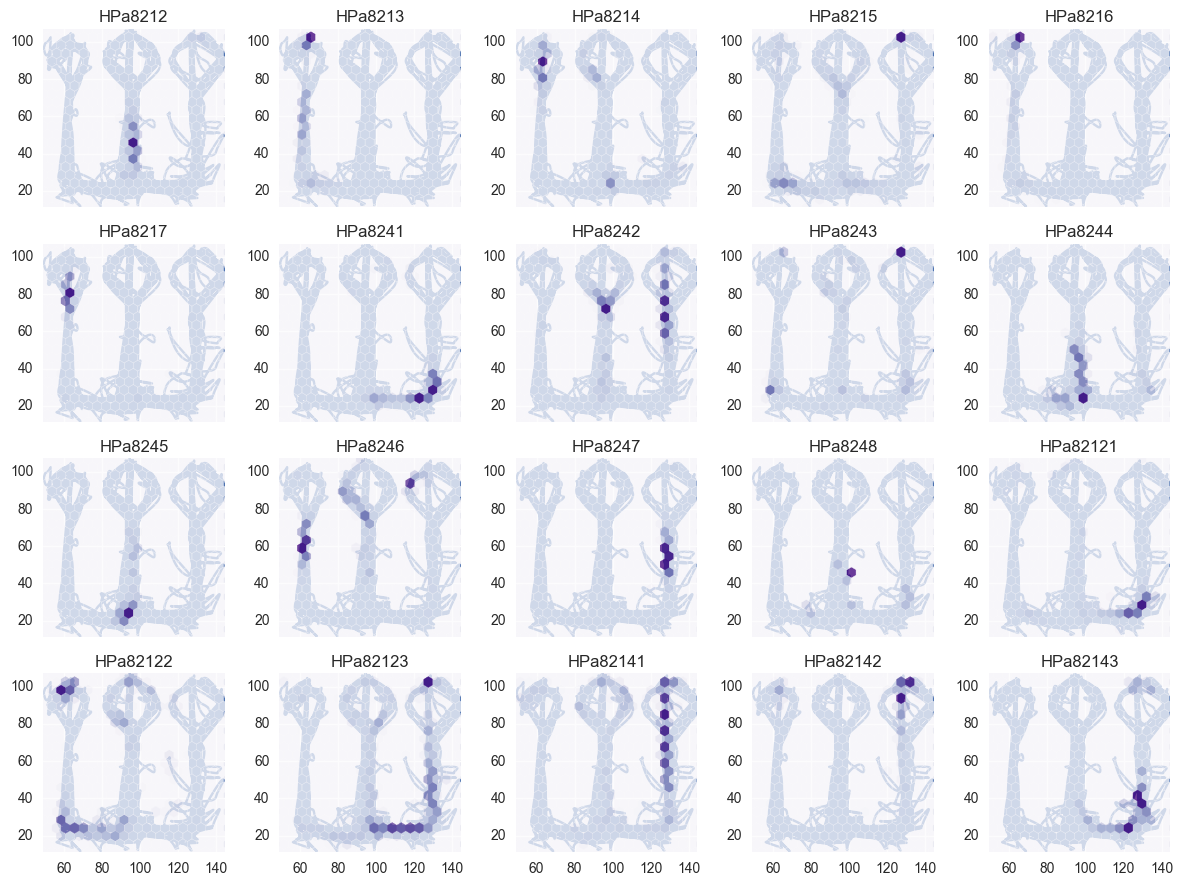

In [12]:
num_neurons = len(fit)
col_wrap = 5
num_plot_rows = int(np.ceil(num_neurons / col_wrap))
fig, axes = plt.subplots(nrows=num_plot_rows, ncols=col_wrap, figsize=(12, 9), sharex=True)
extent = (np.fix(train_trial_info.x_position.min()),
          np.fix(train_trial_info.x_position.max()),
          np.fix(train_trial_info.y_position.min()),
          np.fix(train_trial_info.y_position.max()))

for neuron_ind, ax in enumerate(axes.flatten()[:num_neurons]):
    df = (pd.concat([train_trial_info, train_spikes_data[neuron_ind]], axis=1)
            .query('(is_spike > 0) & (trajectory_direction == "Outbound")'))
    ax.plot(train_trial_info.x_position, train_trial_info.y_position, zorder=1)
    ax.hexbin(df.x_position, df.y_position, zorder=2, alpha=0.75,
              gridsize=20, extent=extent, cmap='Purples')
    ax.set_title(neuron_info.neuron_id[neuron_ind])
    
plt.tight_layout()

### State Transition Matrix

#### Fit transition matrix based on movement data
Estimate separately based on inbound and outbound movements

In [13]:
inbound_state_transitions = ripple_decoding.empirical_movement_transition_matrix(
    train_trial_info[train_trial_info.trajectory_direction == 'Inbound'].linear_distance.values, linear_distance_grid)
outbound_state_transitions = ripple_decoding.empirical_movement_transition_matrix(
    train_trial_info[train_trial_info.trajectory_direction == 'Outbound'].linear_distance.values, linear_distance_grid)

#### Plot state transition matrix to check quality

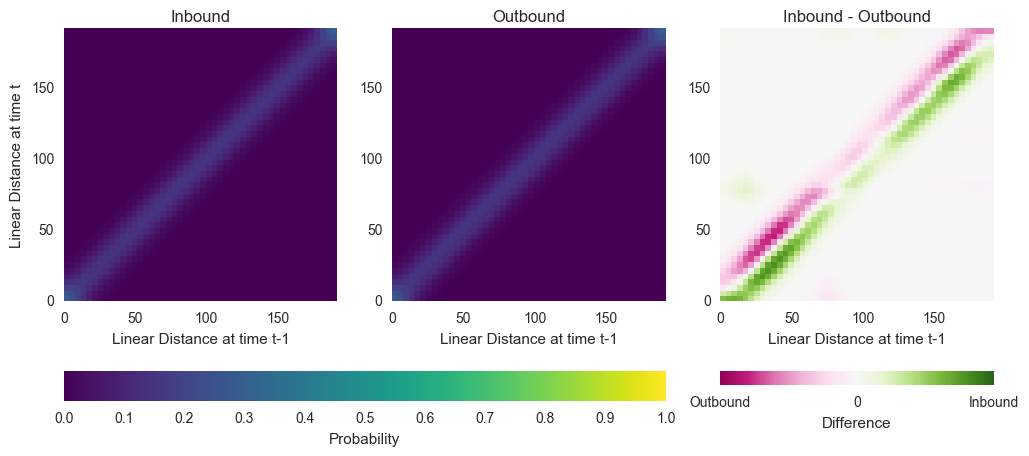

In [14]:
def plot_state_transition(state_transition, grid, ax=None,
                          vmin=0, vmax=1, cmap='viridis'):
    if ax is None:
        ax = plt.gca()
    x_grid, y_grid = np.meshgrid(grid, grid)
    mesh = ax.pcolormesh(x_grid, y_grid, state_transition,
                         cmap=cmap, vmin=vmin, vmax=vmax)
    grid_extent = (grid.min(), grid.max())
    ax.set_xlim(grid_extent)
    ax.set_ylim(grid_extent)
    ax.set_aspect('equal')
    return mesh
    
fig, ax = plt.subplots(1, 3, figsize=(12,6))

plot_state_transition(inbound_state_transitions, linear_distance_grid, ax=ax[0])
ax[0].set_xlabel('Linear Distance at time t-1')
ax[0].set_ylabel('Linear Distance at time t')
ax[0].set_title('Inbound')

mesh1 = plot_state_transition(outbound_state_transitions, linear_distance_grid, ax=ax[1])
ax[1].set_title('Outbound')
ax[1].set_xlabel('Linear Distance at time t-1')

state_transition_difference = inbound_state_transitions - outbound_state_transitions
mesh2 = plot_state_transition(state_transition_difference, linear_distance_grid, ax=ax[2],
                              vmin=-0.01, vmax=0.01, cmap='PiYG')
ax[2].set_title('Inbound - Outbound')
ax[2].set_xlabel('Linear Distance at time t-1')

fig.colorbar(mesh1, ax=ax.ravel().tolist()[:2], label='Probability', orientation='horizontal')
cbar = fig.colorbar(mesh2, ax=ax[2], label='Difference', orientation='horizontal', ticks=[-0.01, 0, 0.01])
cbar.ax.set_xticklabels(['Outbound', '0', 'Inbound']);

#### Make sure state transition columns sum to 1

In [15]:
error_tolerance = 1E-13
check_error = lambda x: np.all(np.abs(x - 1) < error_tolerance)
print(check_error(np.sum(inbound_state_transitions, axis=0)))
print(check_error(np.sum(outbound_state_transitions, axis=0)))

True
True


### Initial conditions
Where the replay trajectory starts.

The **outbound** inital condition is a Gaussian with probability mass at center arm reflecting that the replay trajectory is likely to start at the center arm

The **inbound** inital condition is a Gaussian with probability mass everywhere but at the center arm reflecting that the replay trajectory is likely to start everywhere except at the center arm

In [16]:
linear_distance_grid_bin_size = linear_distance_grid[1] - linear_distance_grid[0]

outbound_initial_conditions = ripple_decoding.normalize_to_probability(
    scipy.stats.norm.pdf(linear_distance_grid_centers, 0, linear_distance_grid_bin_size * 2))

inbound_initial_conditions = ripple_decoding.normalize_to_probability(
    (np.max(outbound_initial_conditions) * np.ones(linear_distance_grid_centers.shape)) -
    outbound_initial_conditions)

#### Plot intial conditions

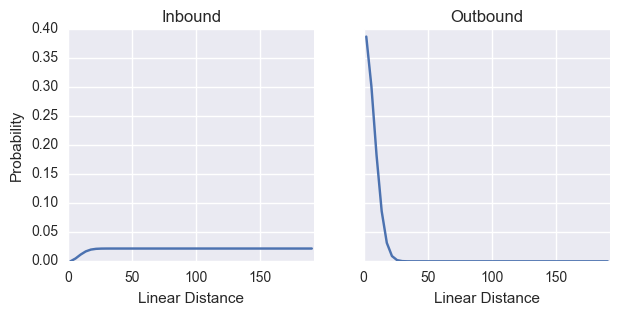

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
ax[0].plot(linear_distance_grid_centers, inbound_initial_conditions)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Linear Distance')
ax[0].set_title('Inbound')
ax[0].set_xlim((linear_distance_grid.min(), linear_distance_grid.max()))
ax[1].plot(linear_distance_grid_centers, outbound_initial_conditions)
ax[1].set_xlabel('Linear Distance')
ax[1].set_title('Outbound')
ax[1].set_xlim((linear_distance_grid.min(), linear_distance_grid.max()));

### Organize into discrete states
Outbound reverse is the same as inbound forward. Double check conditional intensity

In [243]:
import scipy.linalg
discrete_state_names = ['outbound_forward', 'outbound_reverse', 'inbound_forward', 'inbound_reverse']

# Initial Conditions
num_decision_states = len(discrete_state_names)
prior_probability_of_state = 1 / num_decision_states
initial_conditions = np.hstack([outbound_initial_conditions,
                                inbound_initial_conditions,
                                inbound_initial_conditions,
                                outbound_initial_conditions]) * prior_probability_of_state

# State Transition
state_transition = scipy.linalg.block_diag(outbound_state_transitions,
                                           inbound_state_transitions,
                                           inbound_state_transitions,
                                           outbound_state_transitions)

# Encoding Model
conditional_intensity = np.vstack([outbound_conditional_intensity,
                                   outbound_conditional_intensity,
                                   inbound_conditional_intensity,
                                   inbound_conditional_intensity]).T

combined_likelihood_params = dict(likelihood_function=ripple_decoding.poisson_likelihood,
                                  likelihood_kwargs=dict(conditional_intensity=conditional_intensity))

## Ripple decoding

#### Get ripples

In [19]:
ripple_times = ripple_detection.get_epoch_ripples(
    epoch_index[0], animals, sampling_frequency=1500,
    ripple_detection_function=ripple_detection.Kay_method)
spike_ripples_df = [data_processing.reshape_to_segments(
    spikes_datum, ripple_times, concat_axis=1, sampling_frequency=sampling_frequency)
    for spikes_datum in spikes_data]

num_ripples = len(ripple_times)

test_spikes = [np.vstack([df.iloc[:, ripple_ind].dropna().values
                       for df in spike_ripples_df]).T
               for ripple_ind in np.arange(len(ripple_times))]


Detecting ripples for Animal HPa, Day 8, Epoch #2...



#### Decode Ripples

In [268]:
import functools
decode_ripple = functools.partial(ripple_decoding.predict_state,
                                  initial_conditions=initial_conditions,
                                  state_transition=state_transition,
                                  likelihood_function=ripple_decoding.combined_likelihood,
                                  likelihood_kwargs=combined_likelihood_params)

posterior_density = [decode_ripple(ripple_spikes)
                     for ripple_spikes in test_spikes]

def compute_decision_state_probability(posterior_density, num_decision_states):
    num_time = len(posterior_density)
    new_shape = (num_time, num_decision_states, -1)
    return np.sum(np.reshape(posterior_density, new_shape), axis=2)
                  
decision_state_probability = [compute_decision_state_probability(density, num_decision_states)
                              for density in posterior_density]


def compute_max_state(probability):
    end_time_probability = probability[-1, :]
    return (discrete_state_names[np.argmax(end_time_probability)].split('_'),
            np.max(end_time_probability))


def num_unique_neurons_spiking(spikes):
    return spikes.sum(axis=0).nonzero()[0].shape[0]


def num_total_spikes(spikes):
    return int(spikes.sum(axis=(0,1)))

ripple_info = pd.DataFrame([compute_max_state(probability) for probability in decision_state_probability],
                         columns=['ripple_type', 'ripple_state_probability'],
                         index=pd.Index(np.arange(num_ripples) + 1, name='ripple_number'))
ripple_info['ripple_start_time'] = np.asarray(ripple_times)[:, 0]
ripple_info['ripple_end_time'] = np.asarray(ripple_times)[:, 1]
ripple_info['number_of_unique_neurons_spiking'] = [num_unique_neurons_spiking(spikes) for spikes in test_spikes]
ripple_info['number_of_spikes'] = [num_total_spikes(spikes) for spikes in test_spikes]

print(ripple_info.ripple_type.value_counts())
print('\n')
print(ripple_info.number_of_unique_neurons_spiking.value_counts())
print('\n')
print(ripple_info.number_of_spikes.value_counts())

TypeError: unhashable type: 'list'

#### Display ripple category probabilities

In [ ]:
import ipywidgets

def browse_ripple_fits(decision_state_probability, discrete_state_names, sampling_frequency=1500):
    def plot_fits(ripple_ind):
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        lineObjects = plt.plot(time, decision_state_probability[ripple_ind])
        # plt.legend(lineObjects, discrete_state_names)
        for state_ind, state_names in enumerate(discrete_state_names):
                plt.text(time[-1] + (1 / sampling_frequency),
                         decision_state_probability[ripple_ind][-1, state_ind],
                         discrete_state_names[state_ind],
                         color=lineObjects[state_ind].get_color())
        plt.ylim((0, 1))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability')
        plt.title('Ripple #{ripple_number}'.format(ripple_number=ripple_ind+1))
    ipywidgets.interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1))
        
browse_ripple_fits(decision_state_probability, discrete_state_names)

In [ ]:
import ipywidgets
from mpl_toolkits.axes_grid1 import make_axes_locatable

def browse_ripple_densities(posterior_density, discrete_state_names,
                            linear_distance_grid_centers,
                            sampling_frequency=1500):    
    def plot_fits(ripple_ind):
        fig, axes = plt.subplots(2, 2, figsize=(12,9))
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        num_time = posterior_density[ripple_ind].shape[0]
        num_decision_states = len(discrete_state_names)
        new_shape = (num_time, num_decision_states, -1)
        cur_density = np.reshape(posterior_density[ripple_ind], new_shape)
        [time_grid, linear_distance_grid] = np.meshgrid(time, linear_distance_grid_centers)
        for state_ind, ax in enumerate(axes.flatten()):
            try:
                mesh = ax.pcolormesh(time_grid, linear_distance_grid, cur_density[:, state_ind, :].squeeze().T,
                                     cmap='PuRd', vmin=0, vmax=.2)
                ax.set_xlim((time.min(), time.max()))
                ax.set_ylim((linear_distance_grid_centers.min(), linear_distance_grid_centers.max()))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="2%", pad=0.05)
                plt.colorbar(mesh, label='Density', cax=cax)
                ax.set_title(discrete_state_names[state_ind])
            except ValueError:
                pass
            
        
    ipywidgets.interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1))
        
browse_ripple_densities(posterior_density, discrete_state_names,
                        linear_distance_grid_centers)

In [ ]:
cur_tetrode_info.to_json(orient='records')
cur_neuron_info.drop(['spikewidth', 'propbursts', 'numspikes', 'csi', 'meanrate'], axis=1).to_json(orient='records')
trial_info.to_json(orient='index')
spikes_data[0].tojson(orient='split')
pd.MultiIndex.from_tuples(list(itertools.combinations(cur_tetrode_info.index, 2)), names=['tetrode1', 'tetrode2'])